In [1]:
import h5py
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torch.nn.utils import clip_grad_norm_




/home/ferroelectric/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/ferroelectric/.local/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator12recordStreamERKNS_7DataPtrENS0_10CUDAStreamE
  warn(f"Failed to load image Python extension: {e}")


In [2]:

class HDF5Dataset(Dataset):
    def __init__(self, file_path, data_key):
        self.file_path = file_path
        self.data_key = data_key

        # Open the HDF5 file
        self.h5file = h5py.File(file_path, 'r')
        # Get the HDF5 dataset
        self.data = self.h5file[data_key][:]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
       
        image = self.data[index]
        image= torch.from_numpy(image)
        image= torch.cat((image.unsqueeze(0), image.unsqueeze(0), image.unsqueeze(0)), dim=0)
        image=image/image.max()
        # Perform any additional preprocessing or transformations on the image if needed
        # Return the preprocessed image
        return image.to(torch.float32)

# Specify the path to the HDF5 file and the dataset key
file_path = '/home/ferroelectric/RHEED_paper/m3_learning/m3_learning/papers/2023_RHEED_PLD_SrTiO3/Datasets/test6_gaussian_fit_parameters_all-04232023.h5'
dataset_key = 'growth_1/spot_3/raw_image'



# Create an instance of the HDF5Dataset
dataset = HDF5Dataset(file_path, dataset_key)

# Create a data loader for the dataset
batch_size = 300
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [3]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet34

class GaussianRN(nn.Module):
    def __init__(self, func, testing = False):
        super(GaussianRN, self).__init__()
        self.resnet = resnet34(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 5)
        self.func = func
        self.testing = testing
        self.intermediate_outputs = []


    def forward(self, x):
        x=x.to(torch.float32)
        x0 = self.resnet(x)
       
        x2 = self.func(x0)
        self.intermediate_outputs.append(x0)


        if self.testing:
          return x2, x1, x0

        return x2



class GaussianGenerator(nn.Module):
    def __init__(self, img_dim):
        super(GaussianGenerator, self).__init__()
        self.img_dim = img_dim

    def forward(self, params):
        batch_size = params.shape[0]
        mean_x, mean_y, cov_x, cov_y, theta = params.unbind(dim=-1)
        cov_x = torch.clamp(cov_x, min=1e-9)
        cov_y = torch.clamp(cov_y, min=1e-9)

        x = torch.arange(self.img_dim[1], dtype=torch.float32).reshape(-1, 1).repeat(1, self.img_dim[0]).to(params.device)
        y = torch.arange(self.img_dim[0], dtype=torch.float32).reshape(1, -1).repeat(self.img_dim[1], 1).to(params.device)

        x = x.repeat(batch_size, 1, 1)
        y = y.repeat(batch_size, 1, 1)

        rota_matrix = torch.stack([torch.cos(theta), -torch.sin(theta), torch.sin(theta), torch.cos(theta)], dim=-1)
        rota_matrix = rota_matrix.view(batch_size, 2, 2)

        xy = torch.stack([x - mean_x.view(-1, 1, 1), y - mean_y.view(-1, 1, 1)], dim=-1)
        xy = torch.einsum('bijk,bkl->bijl', xy, rota_matrix)

        img = torch.exp(-0.5 * (xy[:, :, :, 0]**2 / (cov_x.view(-1, 1, 1)**2 ) + xy[:, :, :, 1]**2 / (cov_y.view(-1, 1, 1)**2 )))

        

        return img.unsqueeze(1).to(torch.float32)




In [4]:
class HigherOrderLoss(nn.Module):
    def __init__(self, order=2):
        super(HigherOrderLoss, self).__init__()
        self.order = order

    def forward(self, predicted, target):
        # Calculate the higher-order loss
        loss = torch.pow(torch.abs(predicted - target), self.order).mean()
        return loss

In [5]:
# for i in range(5):
images = next(iter(dataset))  # Retrieve a single image from the dataset
image_height = images.shape[1]
image_width = images.shape[2]
net = GaussianRN(GaussianGenerator((image_width,image_height))).cuda()
# criterion = nn.MSELoss()
criterion = HigherOrderLoss(order=2)


num_epochs = 100
lr=1e-3
optimizer = optim.Adam(net.parameters(), lr=lr)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, epochs=num_epochs, max_lr=lr, steps_per_epoch=len(dataloader))
file_path = '/home/ferroelectric/RHEED_paper/m3_learning/m3_learning/papers/2023_RHEED_PLD_SrTiO3/Datasets/test6_gaussian_fit_parameters_all-04232023.h5'
dataset_key = 'growth_1/spot_3/raw_image'
dataset = HDF5Dataset(file_path, dataset_key)
# Create a data loader for the dataset
data_loader = DataLoader(dataset, batch_size=400, shuffle=True)
#   print(f'RUN {i}')


from tqdm import tqdm

for epoch in range(num_epochs):
    running_loss = 0.0
    

    for images in tqdm(data_loader):
        optimizer.zero_grad()
        outputs = net(images.cuda())
        

        loss = criterion(outputs, images.cuda())  # compare outputs with input images for reconstruction
        loss.backward()
        clip_grad_norm_(net.parameters(), 1)

        optimizer.step()
        #scheduler.step()

        running_loss += loss.item()
    average_loss = running_loss / len(data_loader)
        

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss}")






/home/ferroelectric/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ferroelectric/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


100%|██████████| 33/33 [00:02<00:00, 15.36it/s]


Epoch [1/100], Loss: 0.31180713619246625


100%|██████████| 33/33 [00:01<00:00, 21.22it/s]


Epoch [2/100], Loss: 0.051960940049453216


100%|██████████| 33/33 [00:01<00:00, 21.15it/s]


Epoch [3/100], Loss: 0.011303108749967632


100%|██████████| 33/33 [00:01<00:00, 21.06it/s]


Epoch [4/100], Loss: 0.009205136645698187


100%|██████████| 33/33 [00:01<00:00, 21.08it/s]


Epoch [5/100], Loss: 0.008930247135911926


100%|██████████| 33/33 [00:01<00:00, 20.94it/s]


Epoch [6/100], Loss: 0.008866812977375406


100%|██████████| 33/33 [00:01<00:00, 20.91it/s]


Epoch [7/100], Loss: 0.008835611977812016


100%|██████████| 33/33 [00:01<00:00, 21.02it/s]


Epoch [8/100], Loss: 0.008867153897881508


100%|██████████| 33/33 [00:01<00:00, 21.04it/s]


Epoch [9/100], Loss: 0.00881928140579751


100%|██████████| 33/33 [00:01<00:00, 21.01it/s]


Epoch [10/100], Loss: 0.008768730853317362


100%|██████████| 33/33 [00:01<00:00, 20.94it/s]


Epoch [11/100], Loss: 0.008770004817933746


100%|██████████| 33/33 [00:01<00:00, 20.93it/s]


Epoch [12/100], Loss: 0.008845054177623806


100%|██████████| 33/33 [00:01<00:00, 20.96it/s]


Epoch [13/100], Loss: 0.008792654074954264


100%|██████████| 33/33 [00:01<00:00, 20.89it/s]


Epoch [14/100], Loss: 0.008797717308907799


100%|██████████| 33/33 [00:01<00:00, 20.89it/s]


Epoch [15/100], Loss: 0.00877946341466723


100%|██████████| 33/33 [00:01<00:00, 20.94it/s]


Epoch [16/100], Loss: 0.008785476258984118


100%|██████████| 33/33 [00:01<00:00, 20.94it/s]


Epoch [17/100], Loss: 0.008811974728649313


100%|██████████| 33/33 [00:01<00:00, 20.80it/s]


Epoch [18/100], Loss: 0.008828027653648998


100%|██████████| 33/33 [00:01<00:00, 20.90it/s]


Epoch [19/100], Loss: 0.008737593522351799


100%|██████████| 33/33 [00:01<00:00, 20.85it/s]


Epoch [20/100], Loss: 0.00876452135994579


100%|██████████| 33/33 [00:01<00:00, 20.88it/s]


Epoch [21/100], Loss: 0.008790215195128412


100%|██████████| 33/33 [00:01<00:00, 20.82it/s]


Epoch [22/100], Loss: 0.008748716223194744


100%|██████████| 33/33 [00:01<00:00, 20.80it/s]


Epoch [23/100], Loss: 0.00894156236653075


100%|██████████| 33/33 [00:01<00:00, 20.78it/s]


Epoch [24/100], Loss: 0.008806731156779058


100%|██████████| 33/33 [00:01<00:00, 20.82it/s]


Epoch [25/100], Loss: 0.00875216011296619


100%|██████████| 33/33 [00:01<00:00, 20.82it/s]


Epoch [26/100], Loss: 0.008721516552296553


100%|██████████| 33/33 [00:01<00:00, 20.80it/s]


Epoch [27/100], Loss: 0.008725585359515566


100%|██████████| 33/33 [00:01<00:00, 20.80it/s]


Epoch [28/100], Loss: 0.008834273949491255


100%|██████████| 33/33 [00:01<00:00, 20.78it/s]


Epoch [29/100], Loss: 0.008731101554903116


100%|██████████| 33/33 [00:01<00:00, 20.74it/s]


Epoch [30/100], Loss: 0.008730044447337135


100%|██████████| 33/33 [00:01<00:00, 20.75it/s]


Epoch [31/100], Loss: 0.00880579828200015


100%|██████████| 33/33 [00:01<00:00, 20.75it/s]


Epoch [32/100], Loss: 0.008761569180271843


100%|██████████| 33/33 [00:01<00:00, 20.78it/s]


Epoch [33/100], Loss: 0.0087462015111338


100%|██████████| 33/33 [00:01<00:00, 20.73it/s]


Epoch [34/100], Loss: 0.008716639836855007


100%|██████████| 33/33 [00:01<00:00, 20.81it/s]


Epoch [35/100], Loss: 0.008840868305979353


100%|██████████| 33/33 [00:01<00:00, 20.81it/s]


Epoch [36/100], Loss: 0.008726815834189907


100%|██████████| 33/33 [00:01<00:00, 20.81it/s]


Epoch [37/100], Loss: 0.008740736707819231


100%|██████████| 33/33 [00:01<00:00, 20.78it/s]


Epoch [38/100], Loss: 0.008768572923586224


100%|██████████| 33/33 [00:01<00:00, 20.70it/s]


Epoch [39/100], Loss: 0.008794818835502321


100%|██████████| 33/33 [00:01<00:00, 20.75it/s]


Epoch [40/100], Loss: 0.008730201163526737


100%|██████████| 33/33 [00:01<00:00, 20.68it/s]


Epoch [41/100], Loss: 0.008780754255977545


100%|██████████| 33/33 [00:01<00:00, 20.67it/s]


Epoch [42/100], Loss: 0.00882275602921392


100%|██████████| 33/33 [00:01<00:00, 20.69it/s]


Epoch [43/100], Loss: 0.008740565090468435


100%|██████████| 33/33 [00:01<00:00, 20.74it/s]


Epoch [44/100], Loss: 0.00869716921200355


100%|██████████| 33/33 [00:01<00:00, 20.71it/s]


Epoch [45/100], Loss: 0.009113268700964523


100%|██████████| 33/33 [00:01<00:00, 20.64it/s]


Epoch [46/100], Loss: 0.008753064652961311


100%|██████████| 33/33 [00:01<00:00, 20.68it/s]


Epoch [47/100], Loss: 0.008727168269229658


100%|██████████| 33/33 [00:01<00:00, 20.64it/s]


Epoch [48/100], Loss: 0.008722117932682688


100%|██████████| 33/33 [00:01<00:00, 20.51it/s]


Epoch [49/100], Loss: 0.00872370916785616


100%|██████████| 33/33 [00:01<00:00, 20.62it/s]


Epoch [50/100], Loss: 0.008714756843718615


100%|██████████| 33/33 [00:01<00:00, 20.62it/s]


Epoch [51/100], Loss: 0.0087585939433087


100%|██████████| 33/33 [00:01<00:00, 20.64it/s]


Epoch [52/100], Loss: 0.008710048161447048


100%|██████████| 33/33 [00:01<00:00, 20.54it/s]


Epoch [53/100], Loss: 0.0087531293657693


100%|██████████| 33/33 [00:01<00:00, 20.63it/s]


Epoch [54/100], Loss: 0.008879190903495659


100%|██████████| 33/33 [00:01<00:00, 20.61it/s]


Epoch [55/100], Loss: 0.008717062713747675


100%|██████████| 33/33 [00:01<00:00, 20.60it/s]


Epoch [56/100], Loss: 0.008701716323919369


100%|██████████| 33/33 [00:01<00:00, 20.68it/s]


Epoch [57/100], Loss: 0.008810460228811611


100%|██████████| 33/33 [00:01<00:00, 20.62it/s]


Epoch [58/100], Loss: 0.008752237751402638


100%|██████████| 33/33 [00:01<00:00, 20.59it/s]


Epoch [59/100], Loss: 0.008765076738641117


100%|██████████| 33/33 [00:01<00:00, 20.55it/s]


Epoch [60/100], Loss: 0.008858641101555391


100%|██████████| 33/33 [00:01<00:00, 20.58it/s]


Epoch [61/100], Loss: 0.008713612953821817


100%|██████████| 33/33 [00:01<00:00, 20.52it/s]


Epoch [62/100], Loss: 0.00873020686434977


100%|██████████| 33/33 [00:01<00:00, 20.58it/s]


Epoch [63/100], Loss: 0.008892786547993168


100%|██████████| 33/33 [00:01<00:00, 20.58it/s]


Epoch [64/100], Loss: 0.00871699091724374


100%|██████████| 33/33 [00:01<00:00, 20.55it/s]


Epoch [65/100], Loss: 0.008968498473140326


100%|██████████| 33/33 [00:01<00:00, 20.55it/s]


Epoch [66/100], Loss: 0.008693679038322332


100%|██████████| 33/33 [00:01<00:00, 20.53it/s]


Epoch [67/100], Loss: 0.008796656673604792


100%|██████████| 33/33 [00:01<00:00, 20.55it/s]


Epoch [68/100], Loss: 0.008731644685295496


100%|██████████| 33/33 [00:01<00:00, 20.52it/s]


Epoch [69/100], Loss: 0.008756031818462141


100%|██████████| 33/33 [00:01<00:00, 20.54it/s]


Epoch [70/100], Loss: 0.00901135720425483


100%|██████████| 33/33 [00:01<00:00, 20.56it/s]


Epoch [71/100], Loss: 0.008850672874938358


100%|██████████| 33/33 [00:01<00:00, 20.56it/s]


Epoch [72/100], Loss: 0.00868424524863561


100%|██████████| 33/33 [00:01<00:00, 20.51it/s]


Epoch [73/100], Loss: 0.008749012609548641


100%|██████████| 33/33 [00:01<00:00, 20.52it/s]


Epoch [74/100], Loss: 0.00914581266768051


100%|██████████| 33/33 [00:01<00:00, 20.54it/s]


Epoch [75/100], Loss: 0.008769421697114452


100%|██████████| 33/33 [00:01<00:00, 20.52it/s]


Epoch [76/100], Loss: 0.008686253603434923


100%|██████████| 33/33 [00:01<00:00, 20.53it/s]


Epoch [77/100], Loss: 0.008737994950603355


100%|██████████| 33/33 [00:01<00:00, 20.52it/s]


Epoch [78/100], Loss: 0.008743765086612919


100%|██████████| 33/33 [00:01<00:00, 20.50it/s]


Epoch [79/100], Loss: 0.008906074094049858


100%|██████████| 33/33 [00:01<00:00, 20.50it/s]


Epoch [80/100], Loss: 0.00877817872573029


100%|██████████| 33/33 [00:01<00:00, 20.46it/s]


Epoch [81/100], Loss: 0.008865798569538376


100%|██████████| 33/33 [00:01<00:00, 20.43it/s]


Epoch [82/100], Loss: 0.009208739368301449


100%|██████████| 33/33 [00:01<00:00, 20.45it/s]


Epoch [83/100], Loss: 0.008752010452250639


100%|██████████| 33/33 [00:01<00:00, 20.41it/s]


Epoch [84/100], Loss: 0.008739018953885094


100%|██████████| 33/33 [00:01<00:00, 20.21it/s]


Epoch [85/100], Loss: 0.008884951810945164


100%|██████████| 33/33 [00:01<00:00, 20.36it/s]


Epoch [86/100], Loss: 0.008645112372257492


100%|██████████| 33/33 [00:01<00:00, 20.38it/s]


Epoch [87/100], Loss: 0.009068711689024261


100%|██████████| 33/33 [00:01<00:00, 20.35it/s]


Epoch [88/100], Loss: 0.008727252850252571


100%|██████████| 33/33 [00:01<00:00, 20.40it/s]


Epoch [89/100], Loss: 0.0088792284668395


100%|██████████| 33/33 [00:01<00:00, 20.40it/s]


Epoch [90/100], Loss: 0.008900978235584316


100%|██████████| 33/33 [00:01<00:00, 20.33it/s]


Epoch [91/100], Loss: 0.008944296080506208


100%|██████████| 33/33 [00:01<00:00, 20.28it/s]


Epoch [92/100], Loss: 0.008717914450575005


100%|██████████| 33/33 [00:01<00:00, 20.25it/s]


Epoch [93/100], Loss: 0.008312891138661089


100%|██████████| 33/33 [00:01<00:00, 20.23it/s]


Epoch [94/100], Loss: 0.009398239297848759


100%|██████████| 33/33 [00:01<00:00, 20.27it/s]


Epoch [95/100], Loss: 0.008039755027063868


100%|██████████| 33/33 [00:01<00:00, 20.18it/s]


Epoch [96/100], Loss: 0.01077916988199859


100%|██████████| 33/33 [00:01<00:00, 20.29it/s]


Epoch [97/100], Loss: 0.007452445753821821


100%|██████████| 33/33 [00:01<00:00, 20.35it/s]


Epoch [98/100], Loss: 0.008006866696770445


100%|██████████| 33/33 [00:01<00:00, 20.29it/s]


Epoch [99/100], Loss: 0.008849398472882582


100%|██████████| 33/33 [00:01<00:00, 20.24it/s]

Epoch [100/100], Loss: 0.006227877809468544


In [6]:
with torch.no_grad():
  dev=torch.device("cuda")
  data = next(iter(data_loader))
  data_ = data.cpu()
  optimizer.zero_grad()
  outputs = net(data.to('cuda')).cpu()

In [7]:
path = '/home/ferroelectric/RHEED_paper/m3_learning/m3_learning/papers/2023_RHEED_PLD_SrTiO3/Datasets/test6_gaussian_fit_parameters_all-04232023.h5'
manual_im=[]
with h5py.File(path, 'r') as h5:
    for i in range(100):
        manual_im.append(h5['growth_1']['spot_3']['reconstructed_image'][i])
    

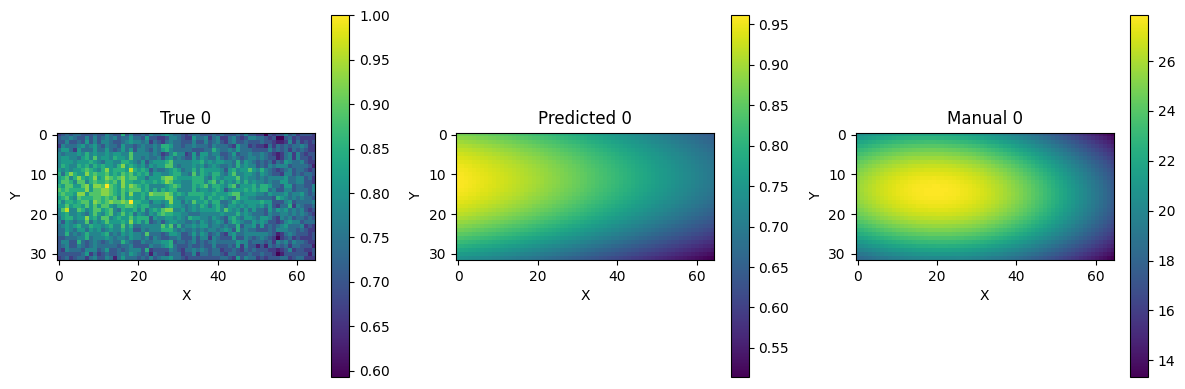

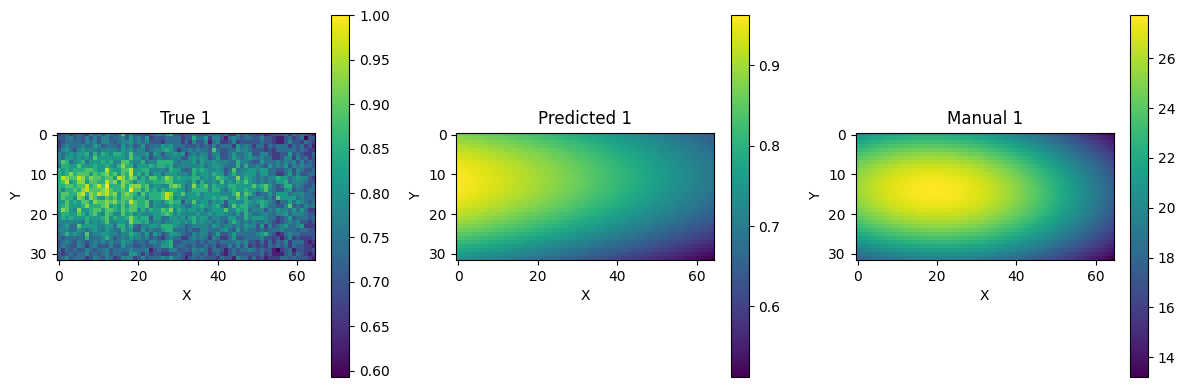

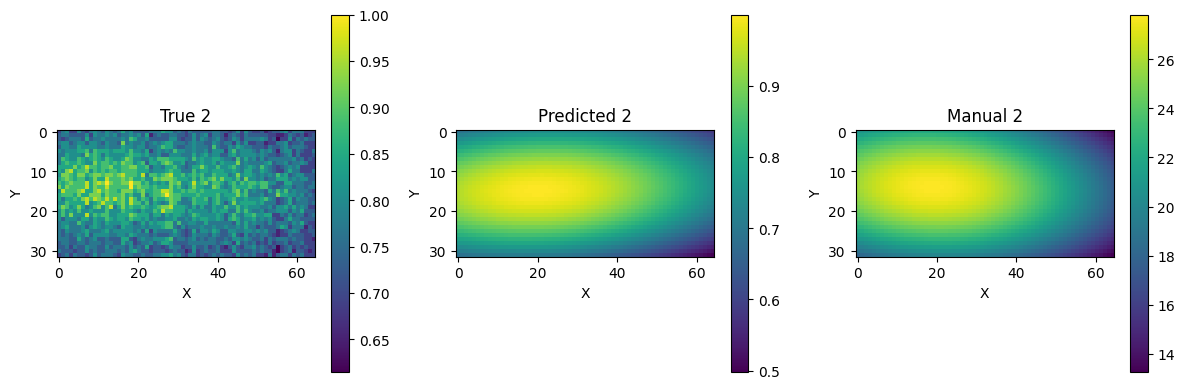

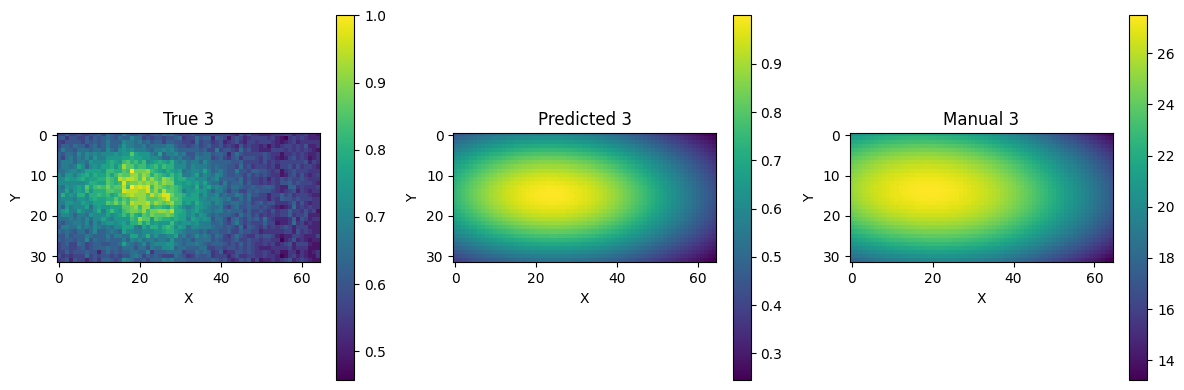

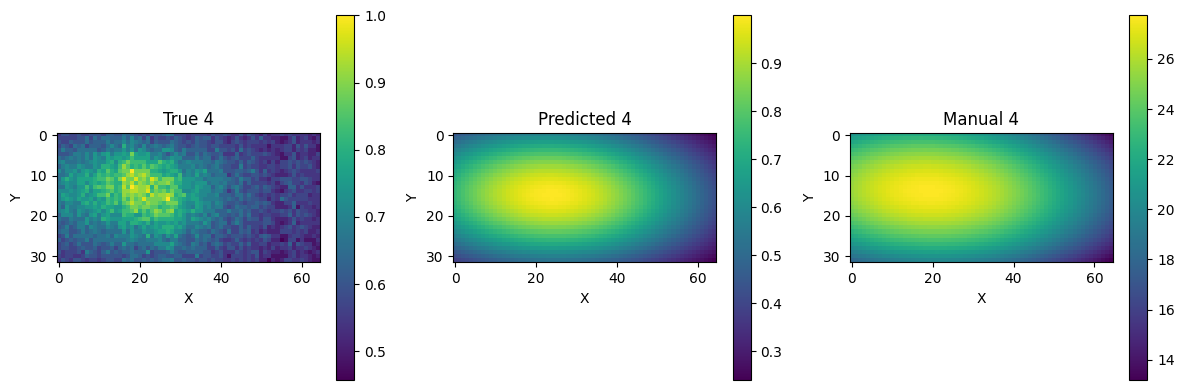

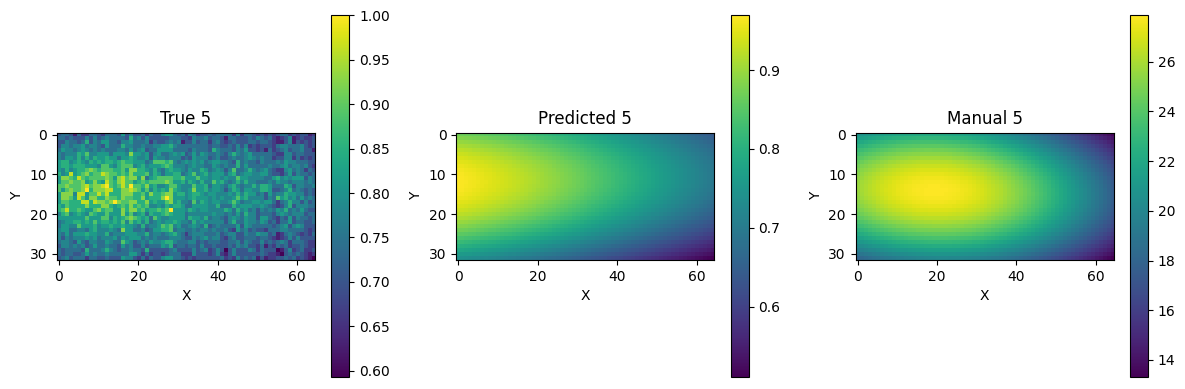

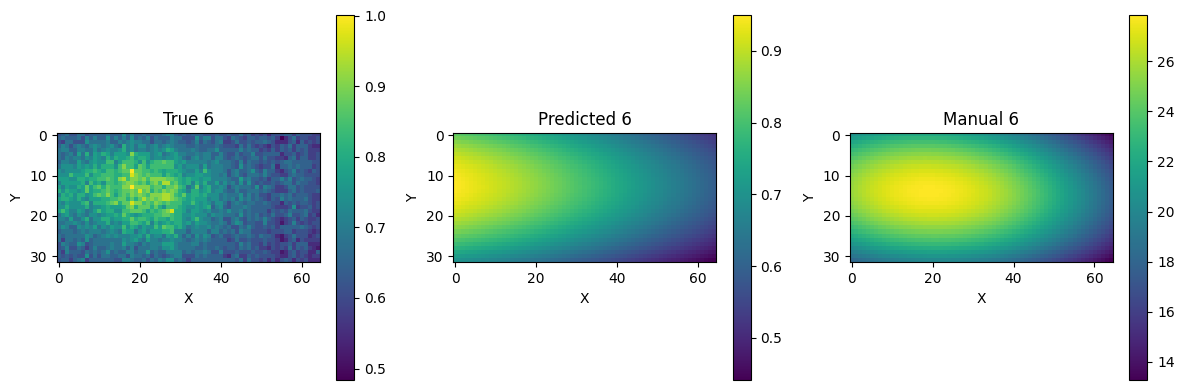

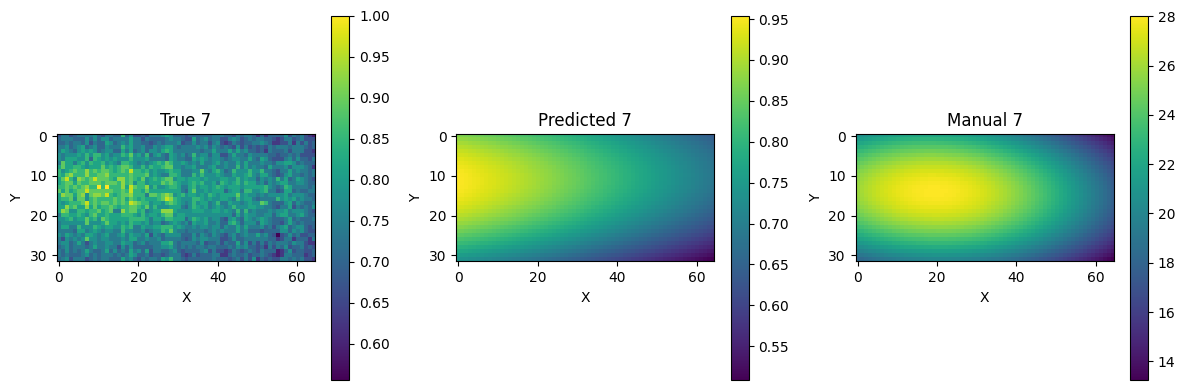

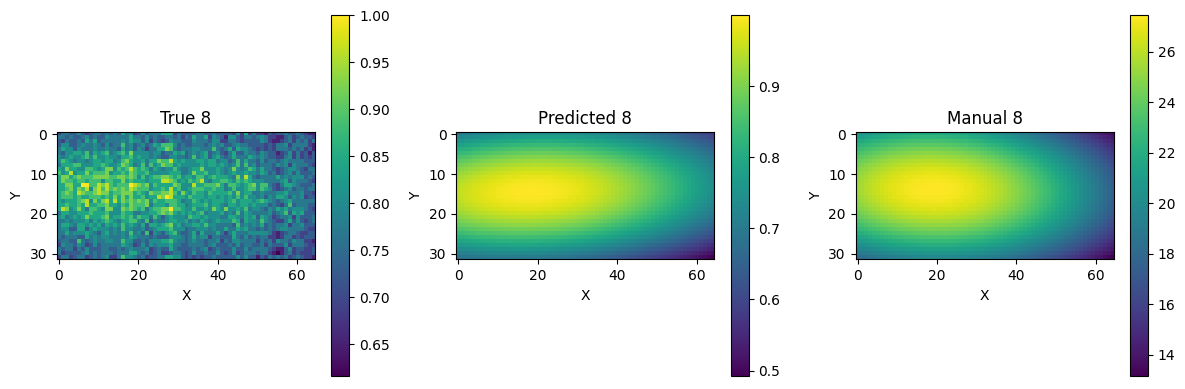

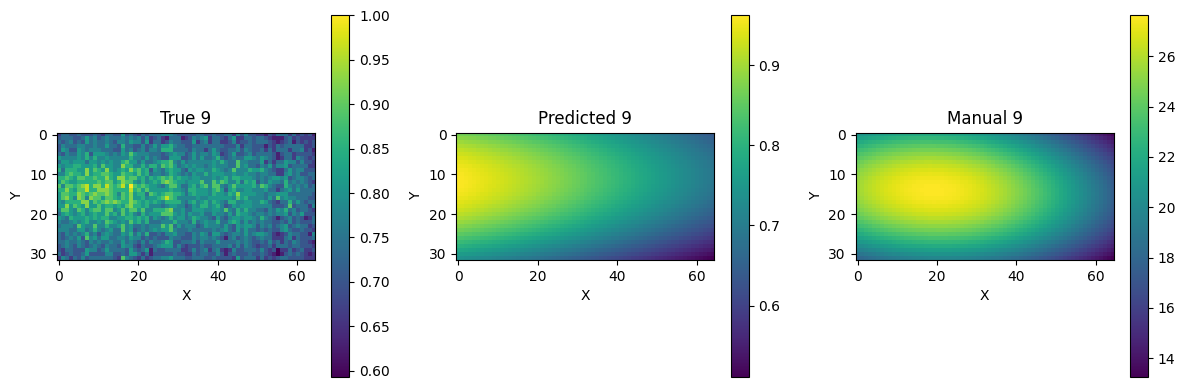

In [8]:

import matplotlib.pyplot as plt

for i in range(10):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    # Plot true image
    im0 = axs[0].imshow(data[i, 0])
    axs[0].set_title(f'True {i}')
    axs[0].set_xlabel('X')
    axs[0].set_ylabel('Y')
    fig.colorbar(im0, ax=axs[0])

    # Plot predicted image
    im1 = axs[1].imshow(outputs[i, 0])
    axs[1].set_title(f'Predicted {i}')
    axs[1].set_xlabel('X')
    axs[1].set_ylabel('Y')
    fig.colorbar(im1, ax=axs[1])

    # Plot manual image
    im2 = axs[2].imshow(manual_im[i])
    axs[2].set_title(f'Manual {i}')
    axs[2].set_xlabel('X')
    axs[2].set_ylabel('Y')
    fig.colorbar(im2, ax=axs[2])

    # Adjust the layout and spacing
    plt.tight_layout()

    # Save the figure
    plt.savefig(f'images_{i}.png')

    # Display the figure
    plt.show()

